# Example usage of spectraxai for explaining models

## Load the example dataset

In [1]:
from spectraxai.data import load_GR_SSL

dataset = load_GR_SSL(subsampling=10, properties=["OM", "Sand_Fraction"])

## PreHocAnalysis before developing any models

### Plot mean +- sd of the spectra

/home/nikos/anaconda3/envs/spectraxai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text(0, 0.5, 'Reflectance')

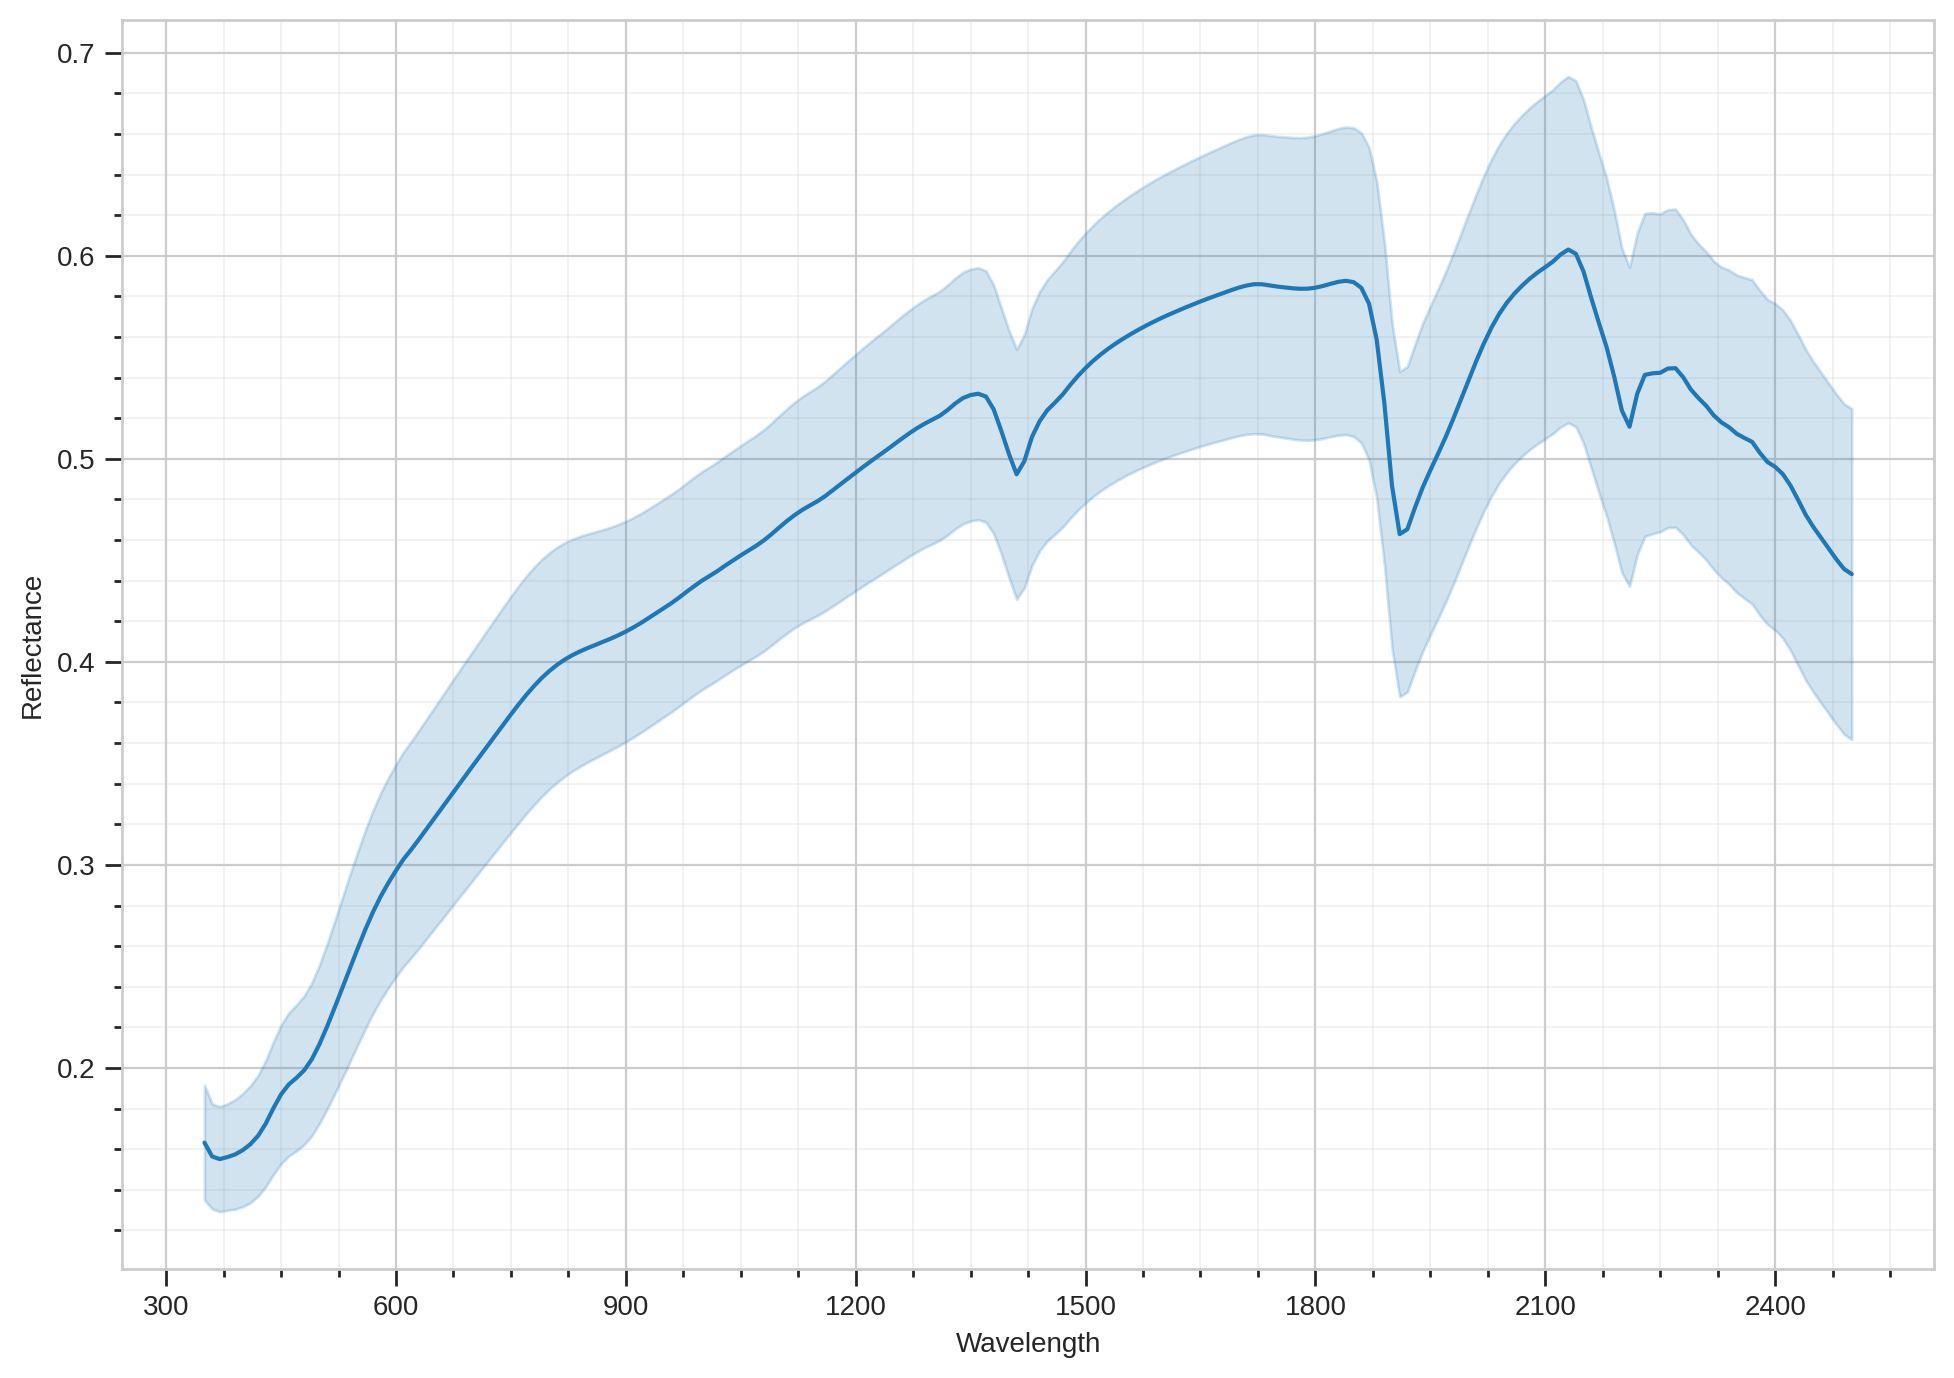

In [2]:
from spectraxai.explain import PreHocAnalysis

xai = PreHocAnalysis(dataset)
ax = xai.mean_spectrum()
ax.set_ylabel("Reflectance")

### Correlogram of the top features

This plot identifies the most important features according to Pearson's correlation coefficient and plots the relationship between input and output.

Here we get extra fancy and perform our pre-hoc analysis on the Abs+SNV spectra.

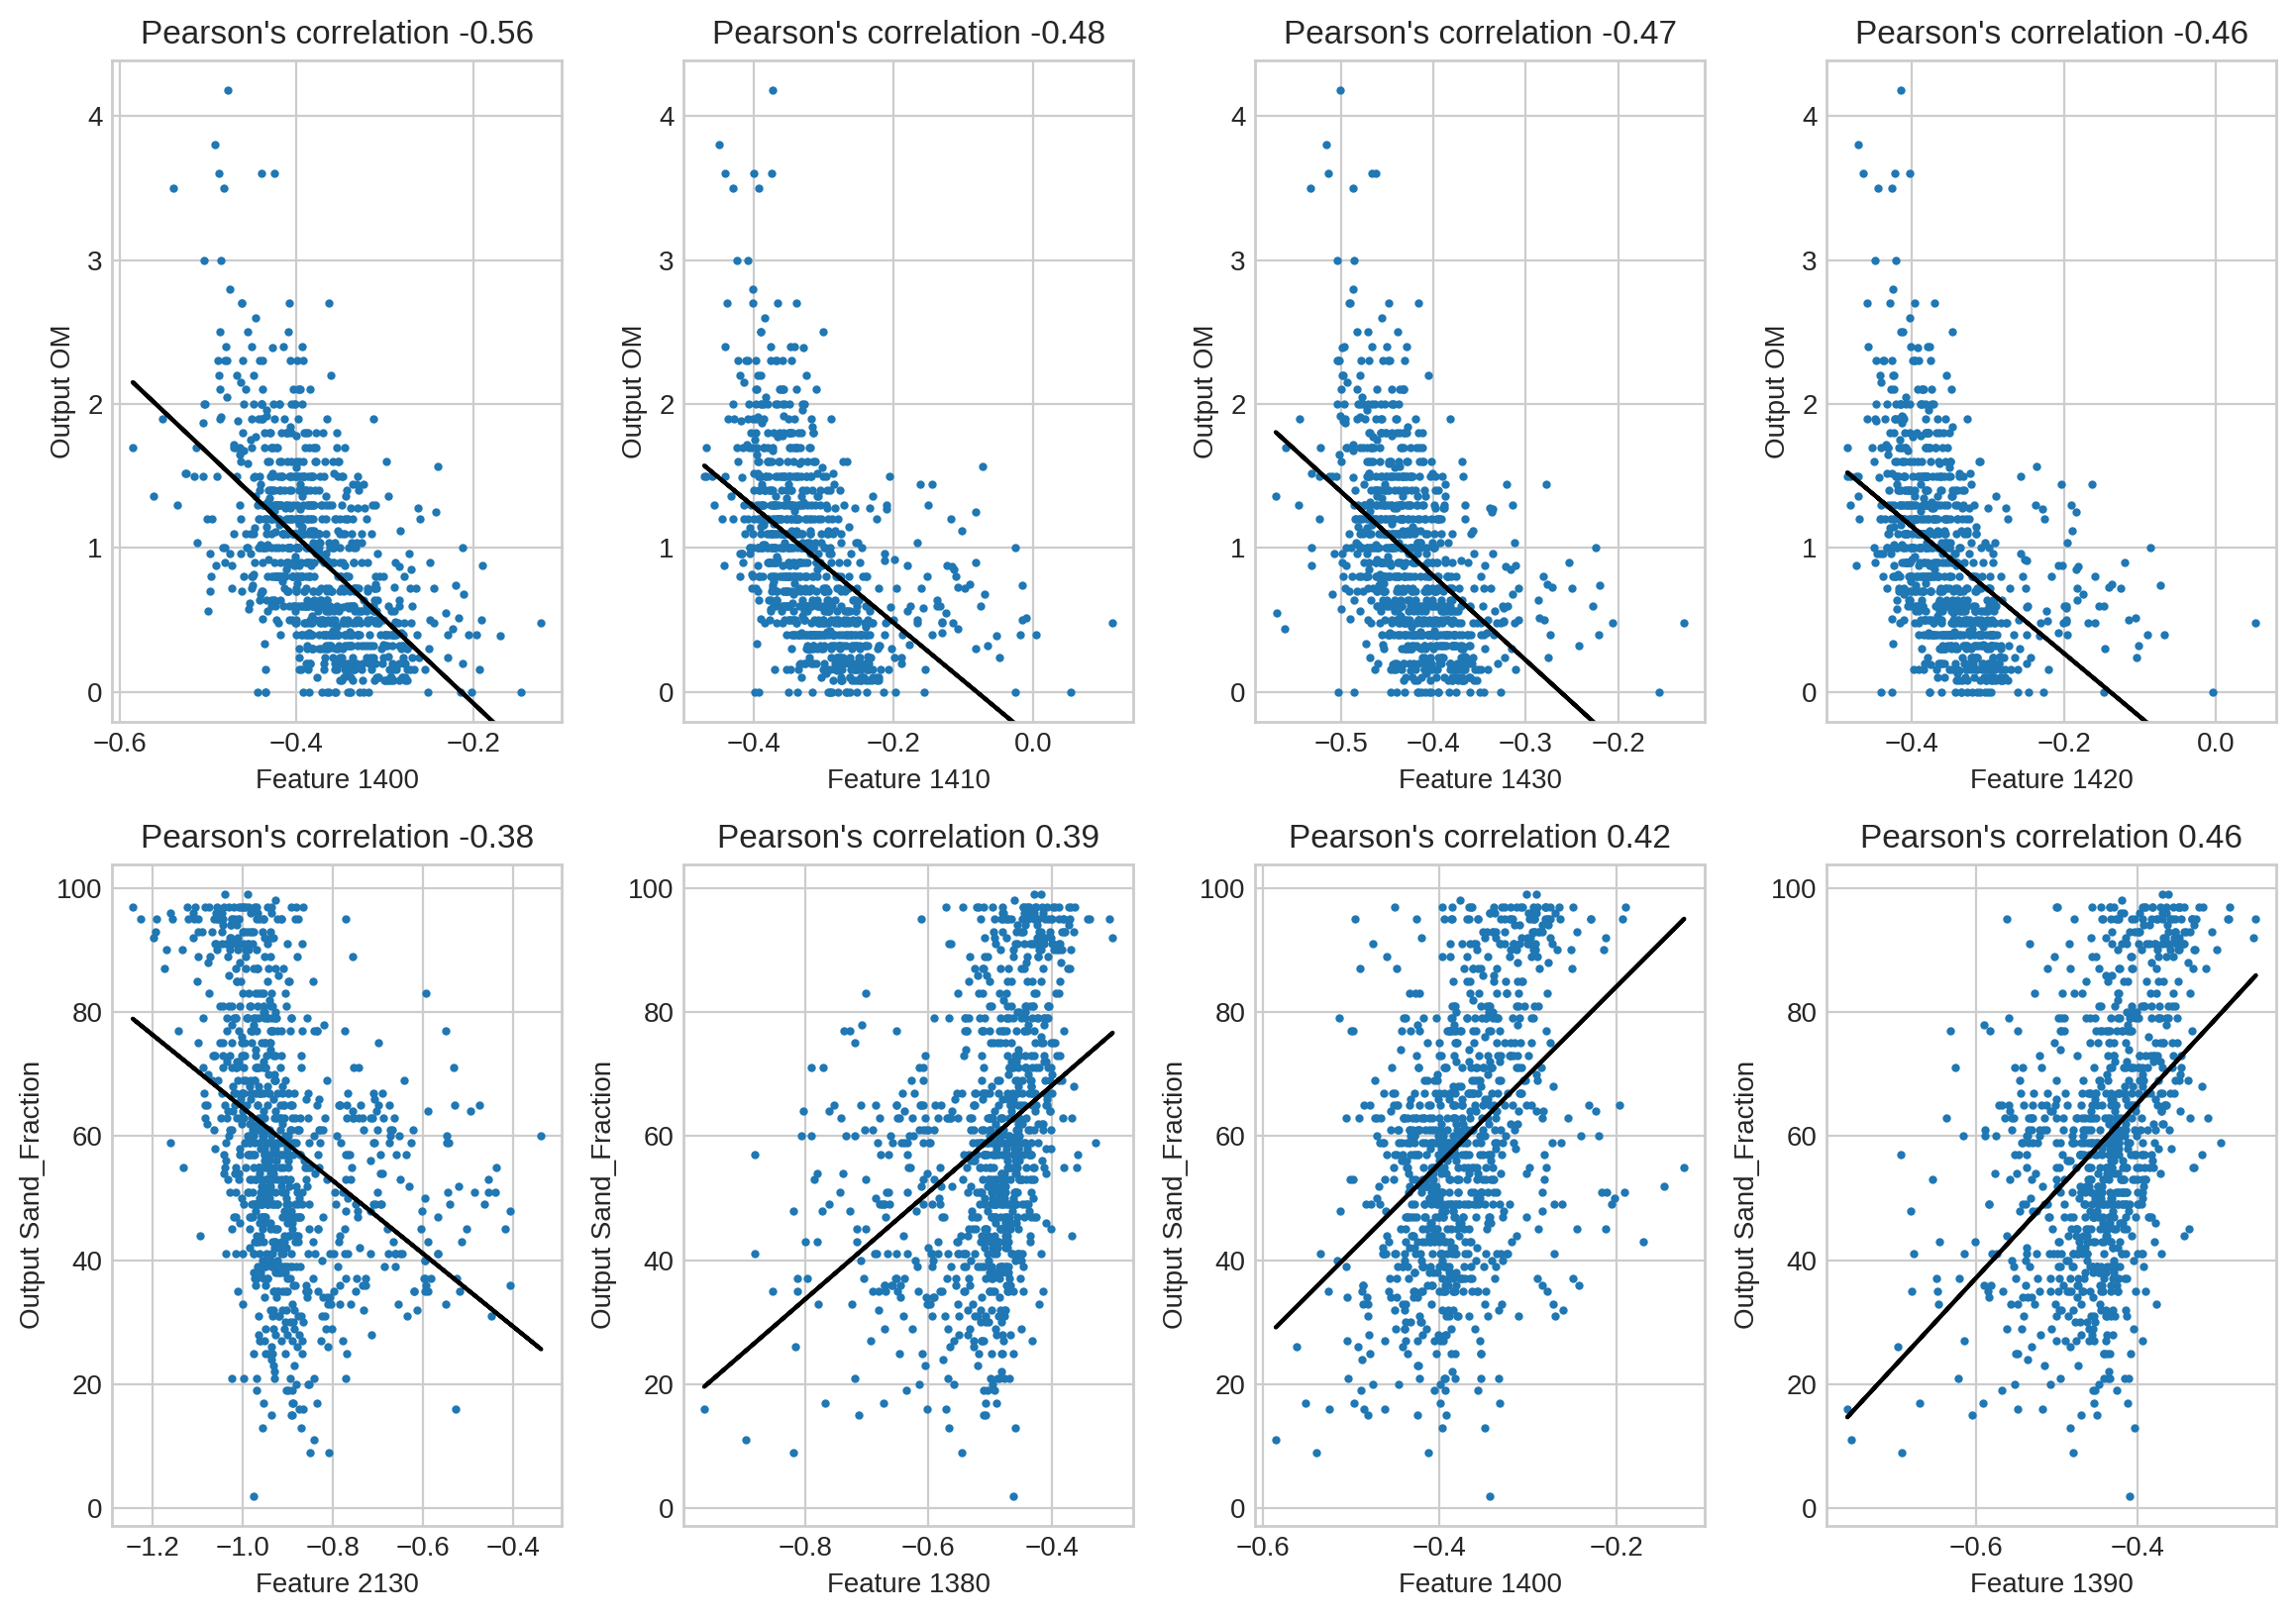

In [3]:
from spectraxai.spectra import SpectralPreprocessing

xai = PreHocAnalysis(dataset.preprocess([SpectralPreprocessing.ABS, SpectralPreprocessing.SNV]))
axes = xai.correlogram(top=4)

### Bar plot of mutual information-based importance

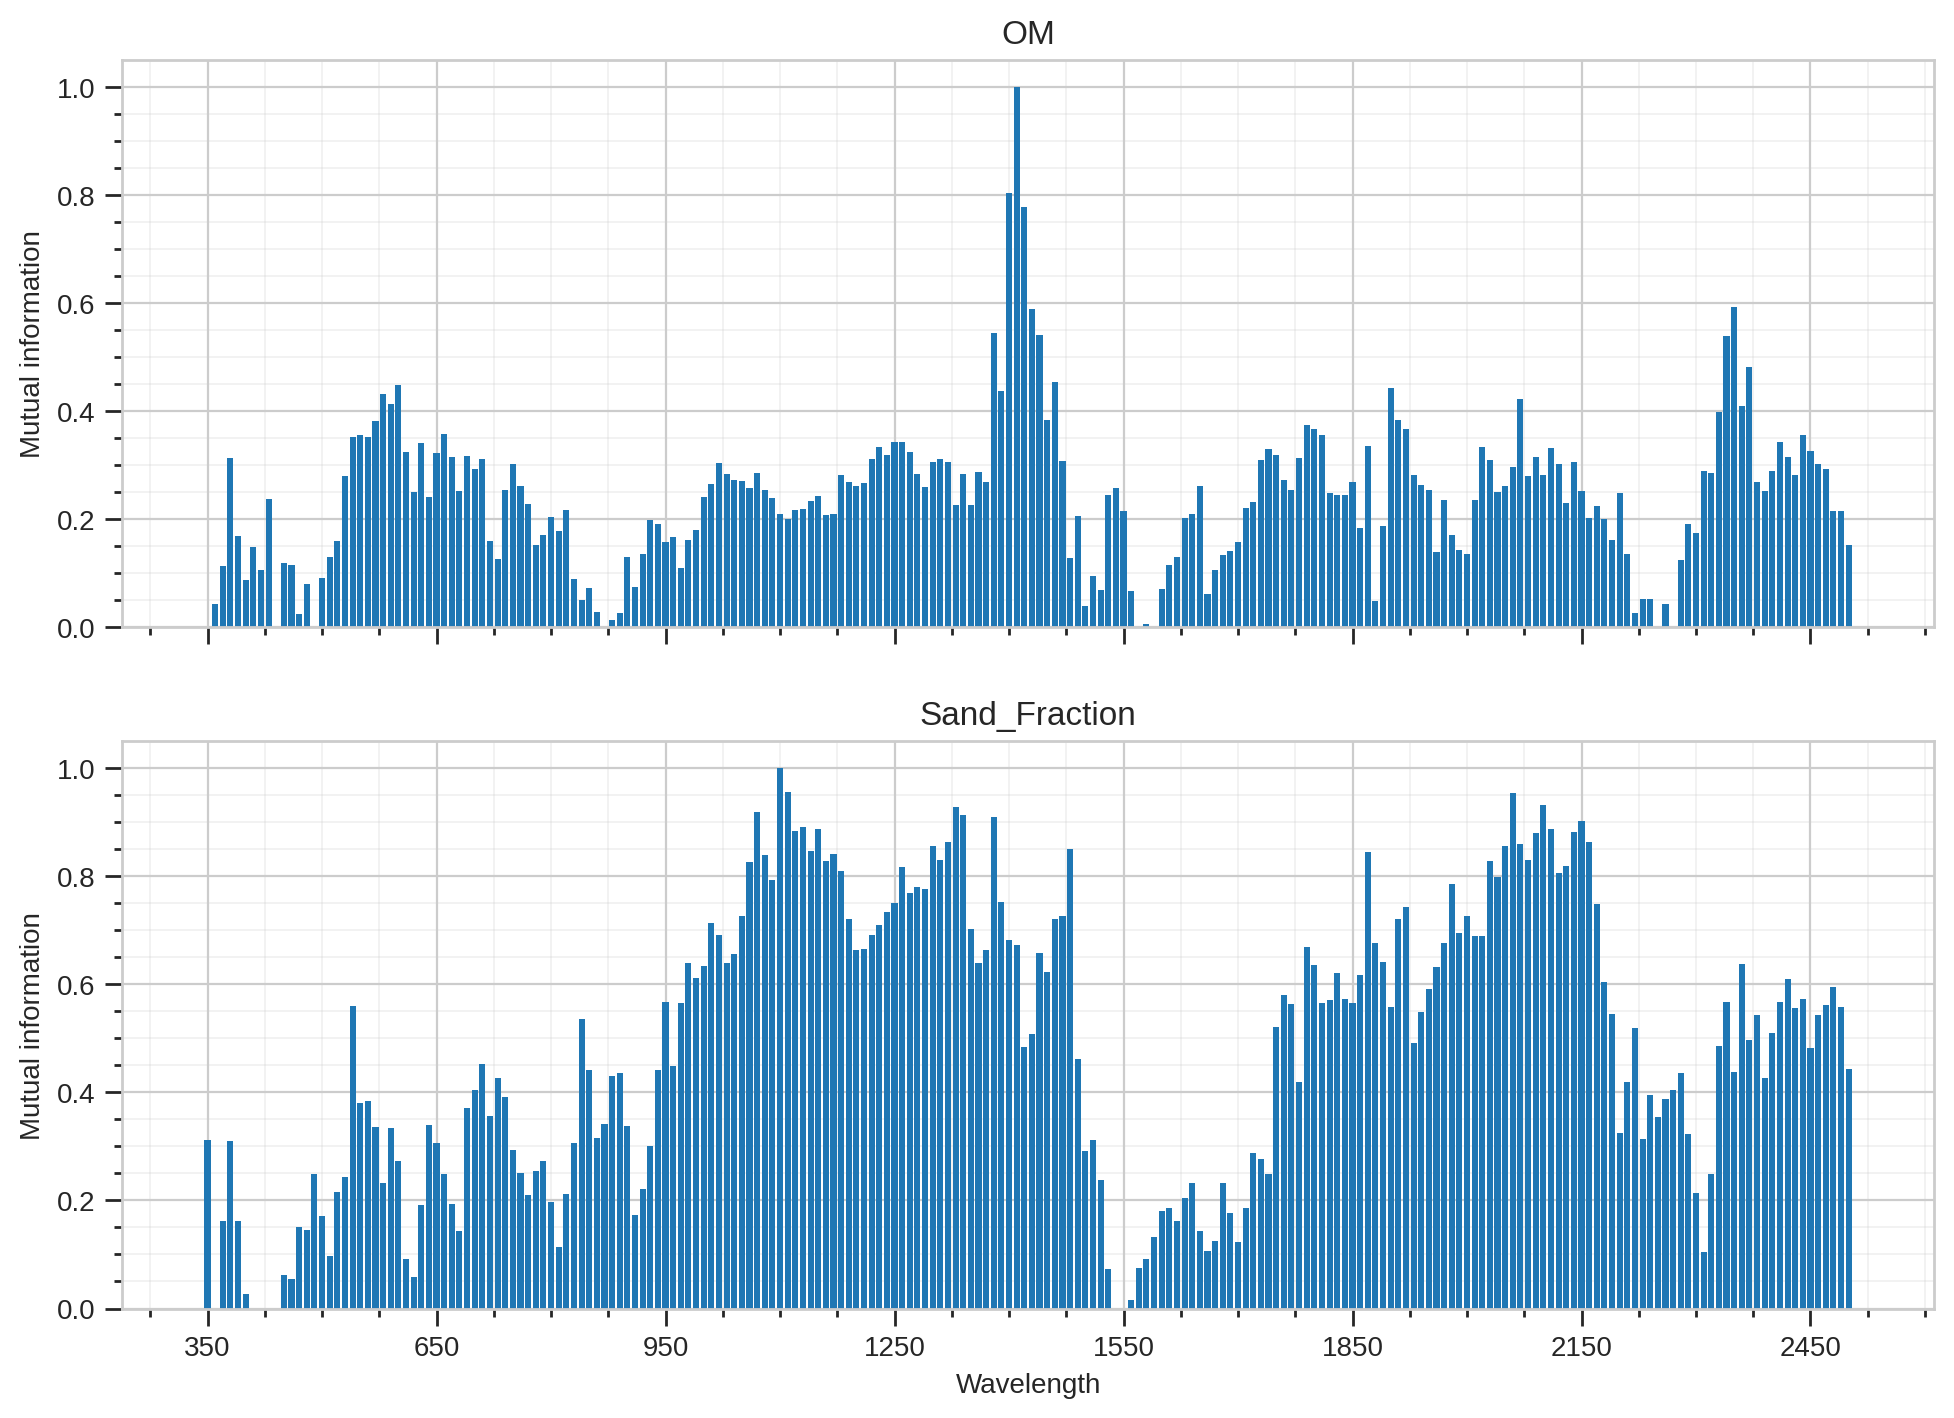

In [4]:
from spectraxai.explain import FeatureRanking

axes = xai.bar_plot_importance(method=FeatureRanking.MI)

### Most important wavelength according to F-statistic-based importance for OM

In [5]:
import numpy as np

f_statistic = xai.feature_importance(method=FeatureRanking.F_STATISTIC)
dataset.X_names[np.argmax(f_statistic[0])]

1400

### Spectral plot of the mean spectra for a given output range and specific pre-treatments

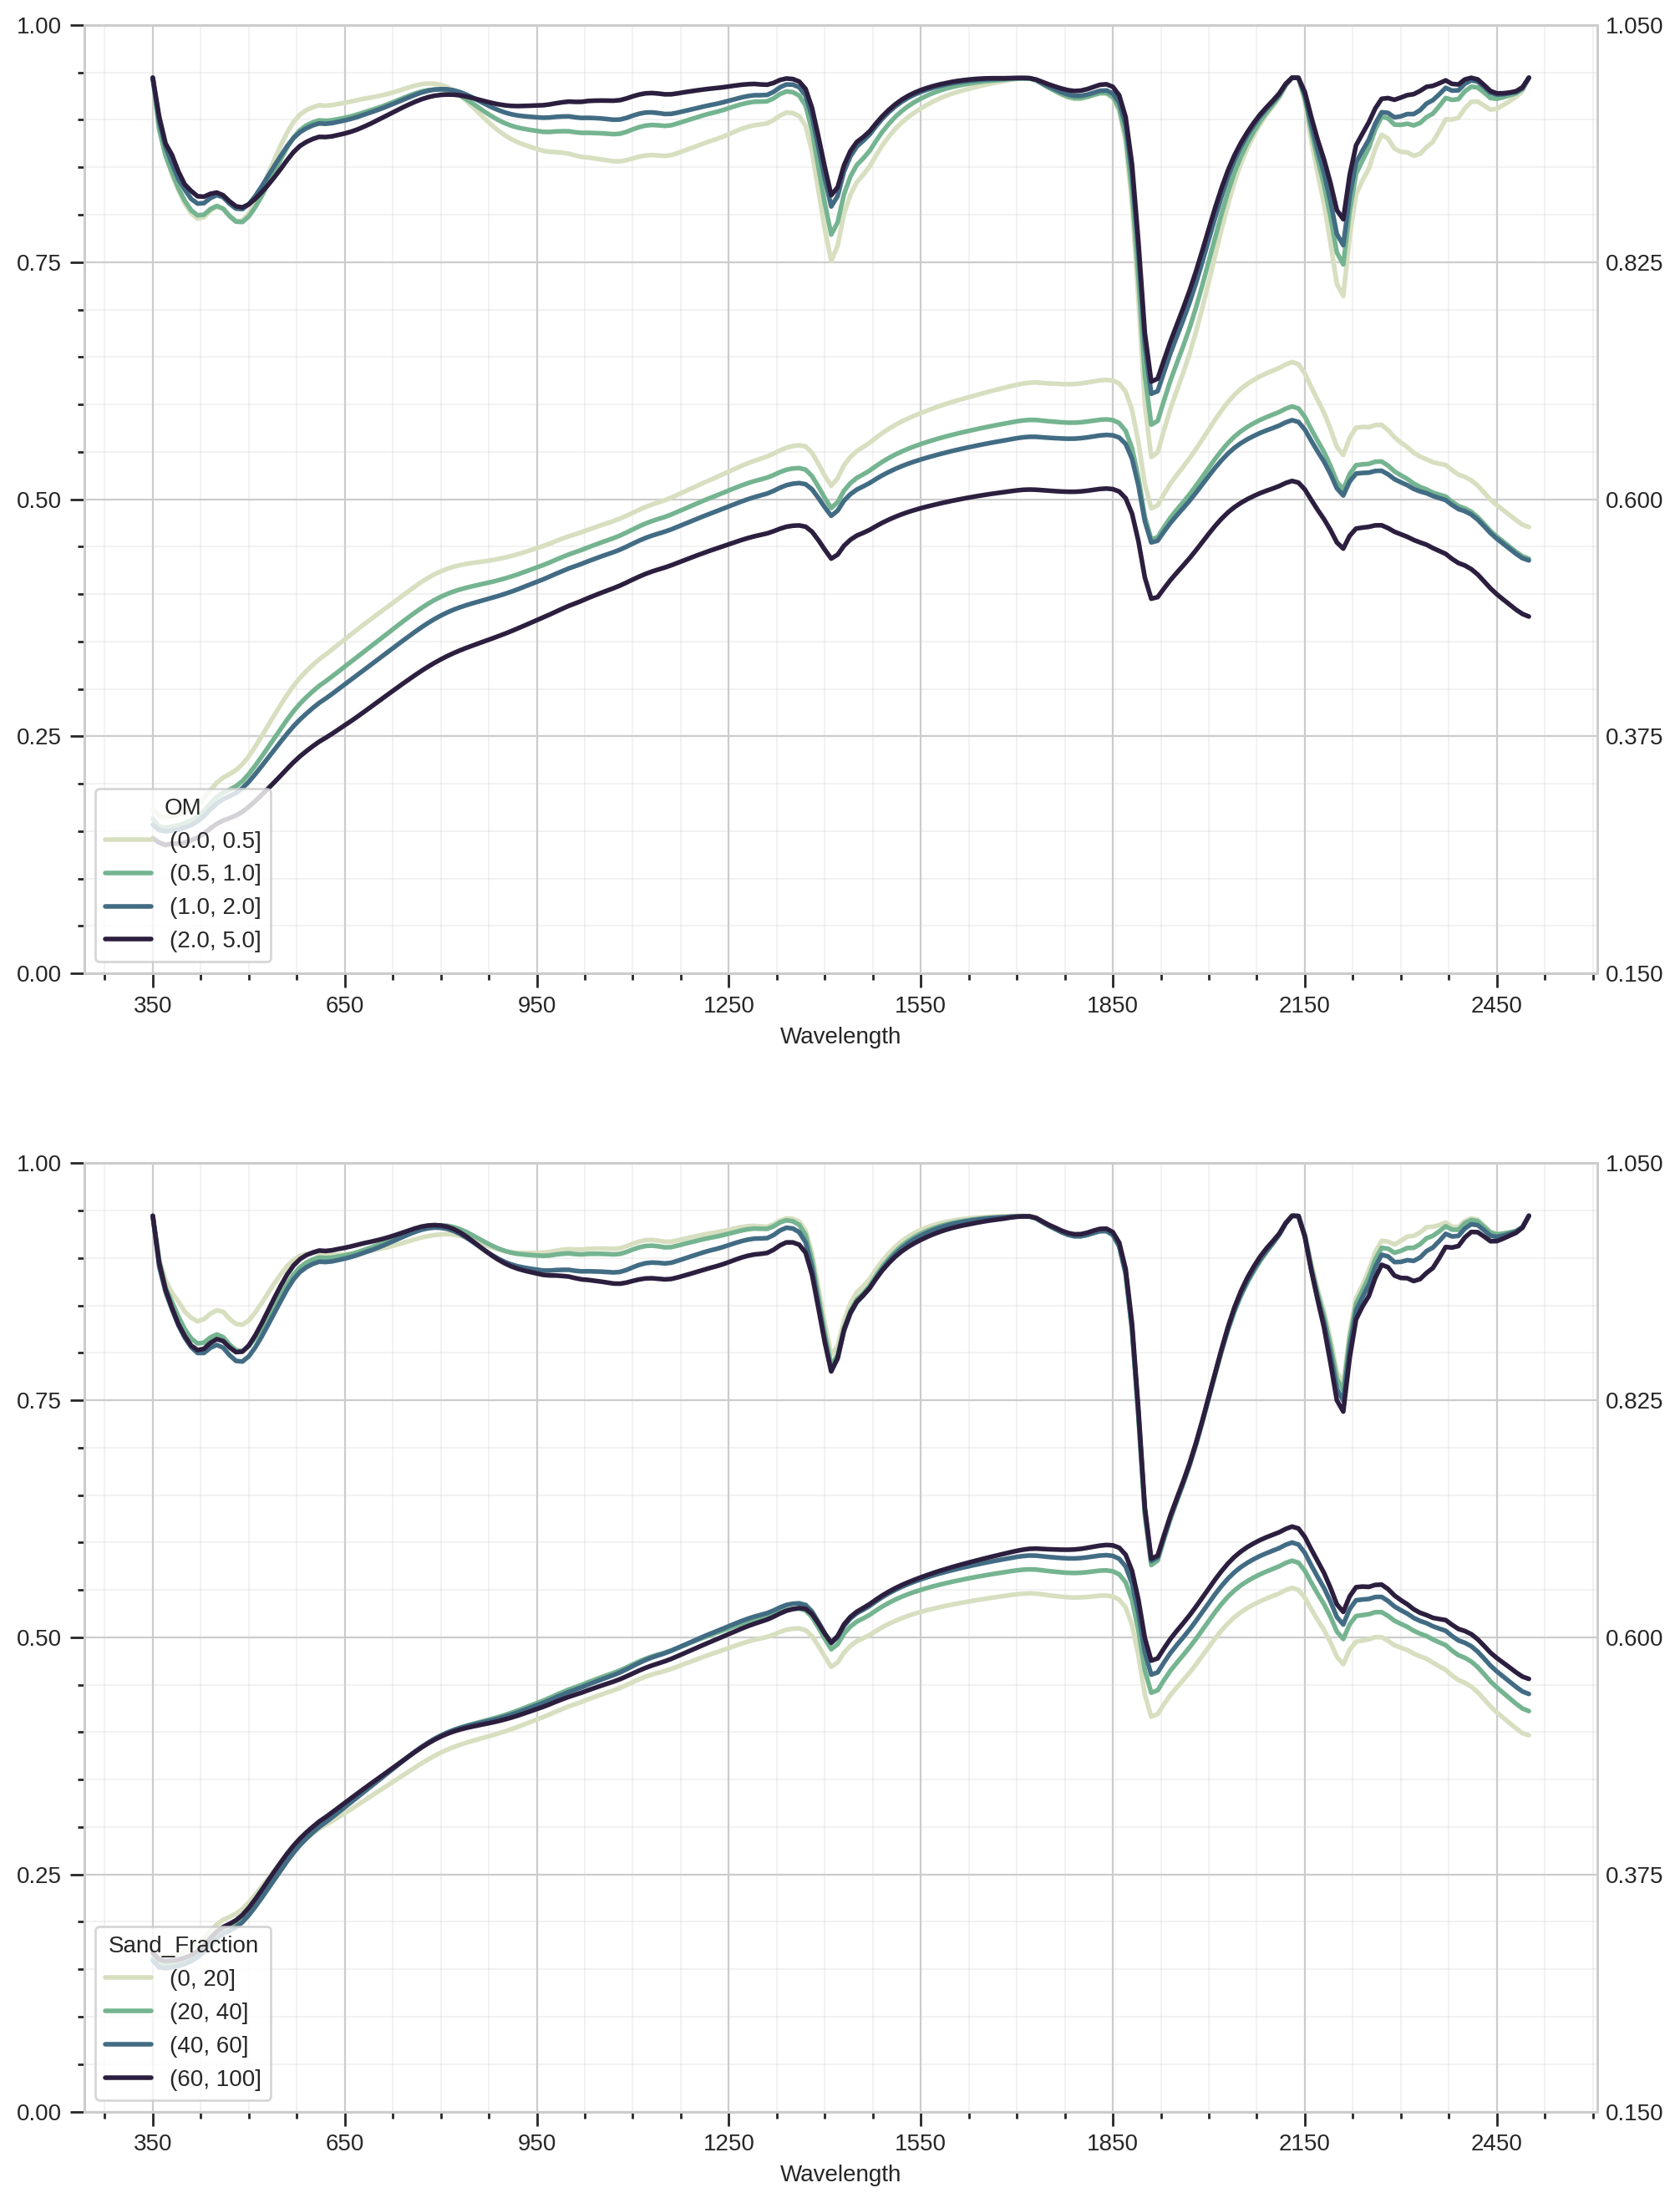

In [6]:
axes = PreHocAnalysis(dataset).mean_spectrum_by_range(
    y_ranges=[
        np.array([0, 0.5, 1.0, 2.0, 5.0]),
        np.array([0, 20, 40, 60, 100])
    ],
    preprocesses=[
        SpectralPreprocessing.NONE,
        [SpectralPreprocessing.ABS, SpectralPreprocessing.CR]
    ],
    ylims = [
        [0, 1],
        [0.15, 1.05],
    ]
)

## PostHocAnalysis with PLS

Depicting model-specific metrics and interpretations

### Train the model

In [7]:
from spectraxai.dataset import DatasetSplit
from spectraxai.models import Model, StandardModel

idx_trn, idx_tst = dataset.train_test_split(DatasetSplit.RANDOM, 0.8)
pls = StandardModel(Model.PLS)
results = pls.fit_and_predict(dataset, idx_trn=idx_trn, get_model=True)
results

,N,RMSE,R2,RPIQ,output,pre_process,val_score,n_components,feature_importance,training_time,testing_time,model
0,186,0.398353,0.546258,2.237964,OM,NONE,0.483171,17,"[3.3197253990365847, 2.5408810222448697, 2.216...",11.566253,0.000401,PLSRegression(n_components=17)
1,186,13.516627,0.535978,1.923557,Sand_Fraction,NONE,0.483171,17,"[3.3197253990365847, 2.5408810222448697, 2.216...",11.566253,0.000401,PLSRegression(n_components=17)


### Bar plot of the feature importance as identified by the model

For PLS, these are the VIP scores

<AxesSubplot:xlabel='Wavelength', ylabel='Importance'>

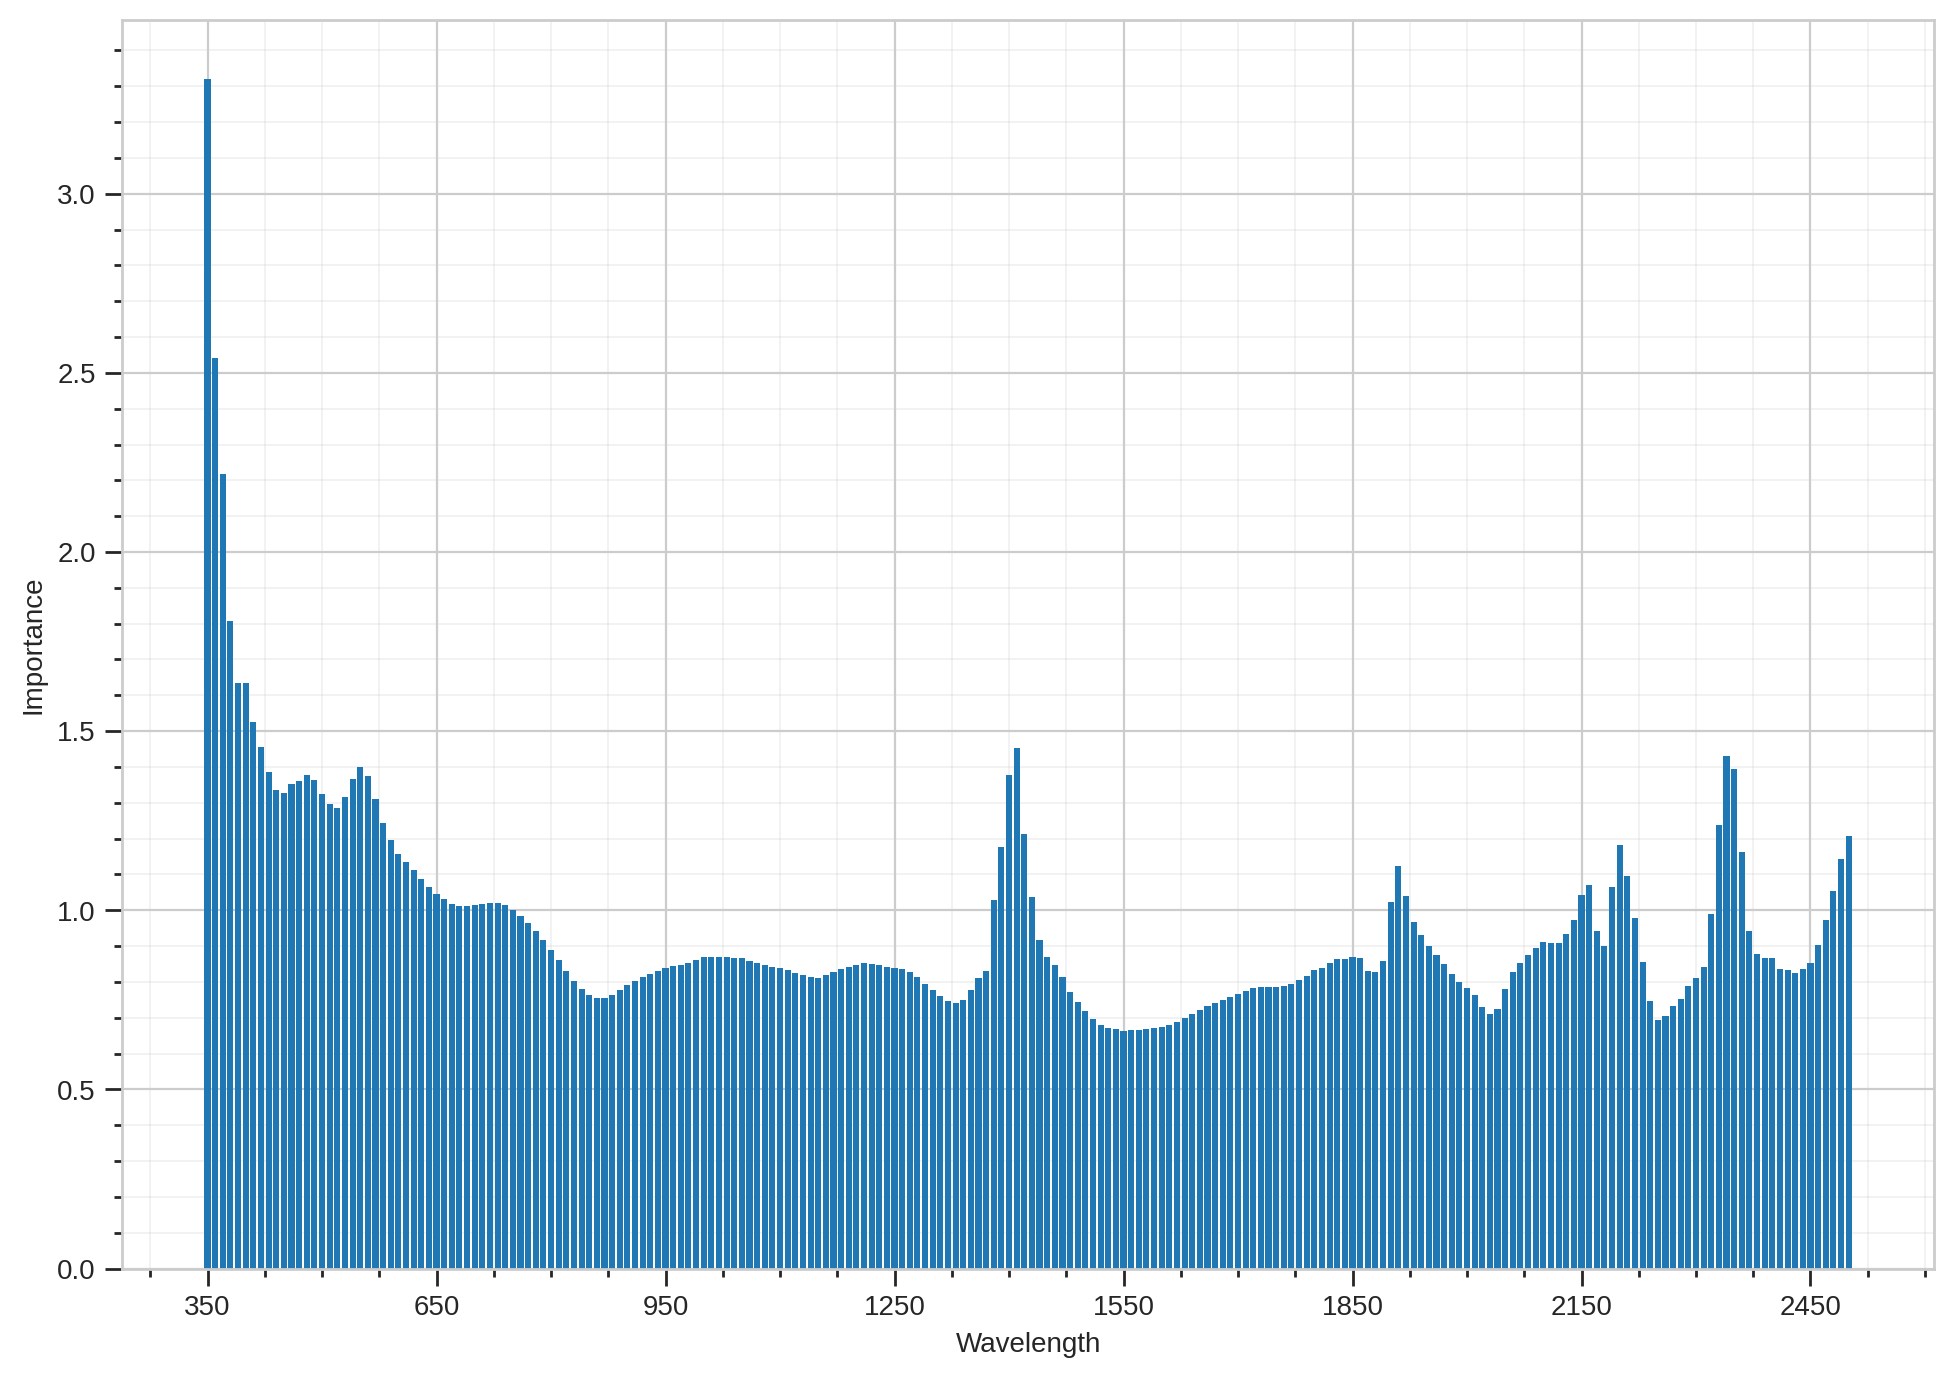

In [8]:
from spectraxai.explain import PostHocAnalysis

xai = PostHocAnalysis(dataset)
xai.bar_plot_importance(results.iloc[0]["feature_importance"])

### Circular bar plot of the feature importance as identified by the model

Keep the 50 most important for visualization purposes

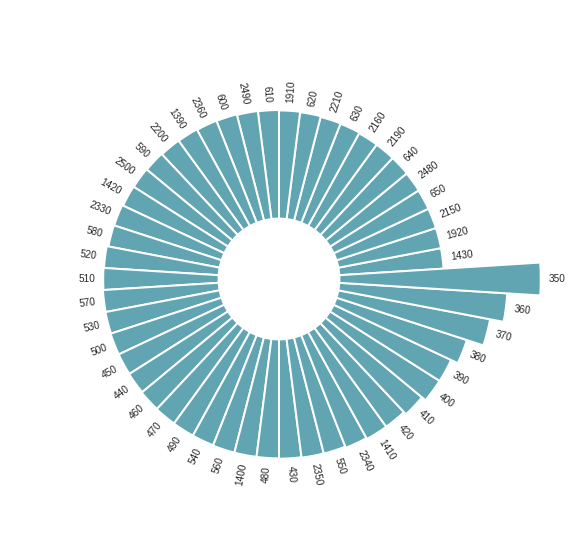

In [9]:
ax = xai.circular_bar_plot_importance(results.iloc[0]["feature_importance"], top=50)

### Permutation feature importance

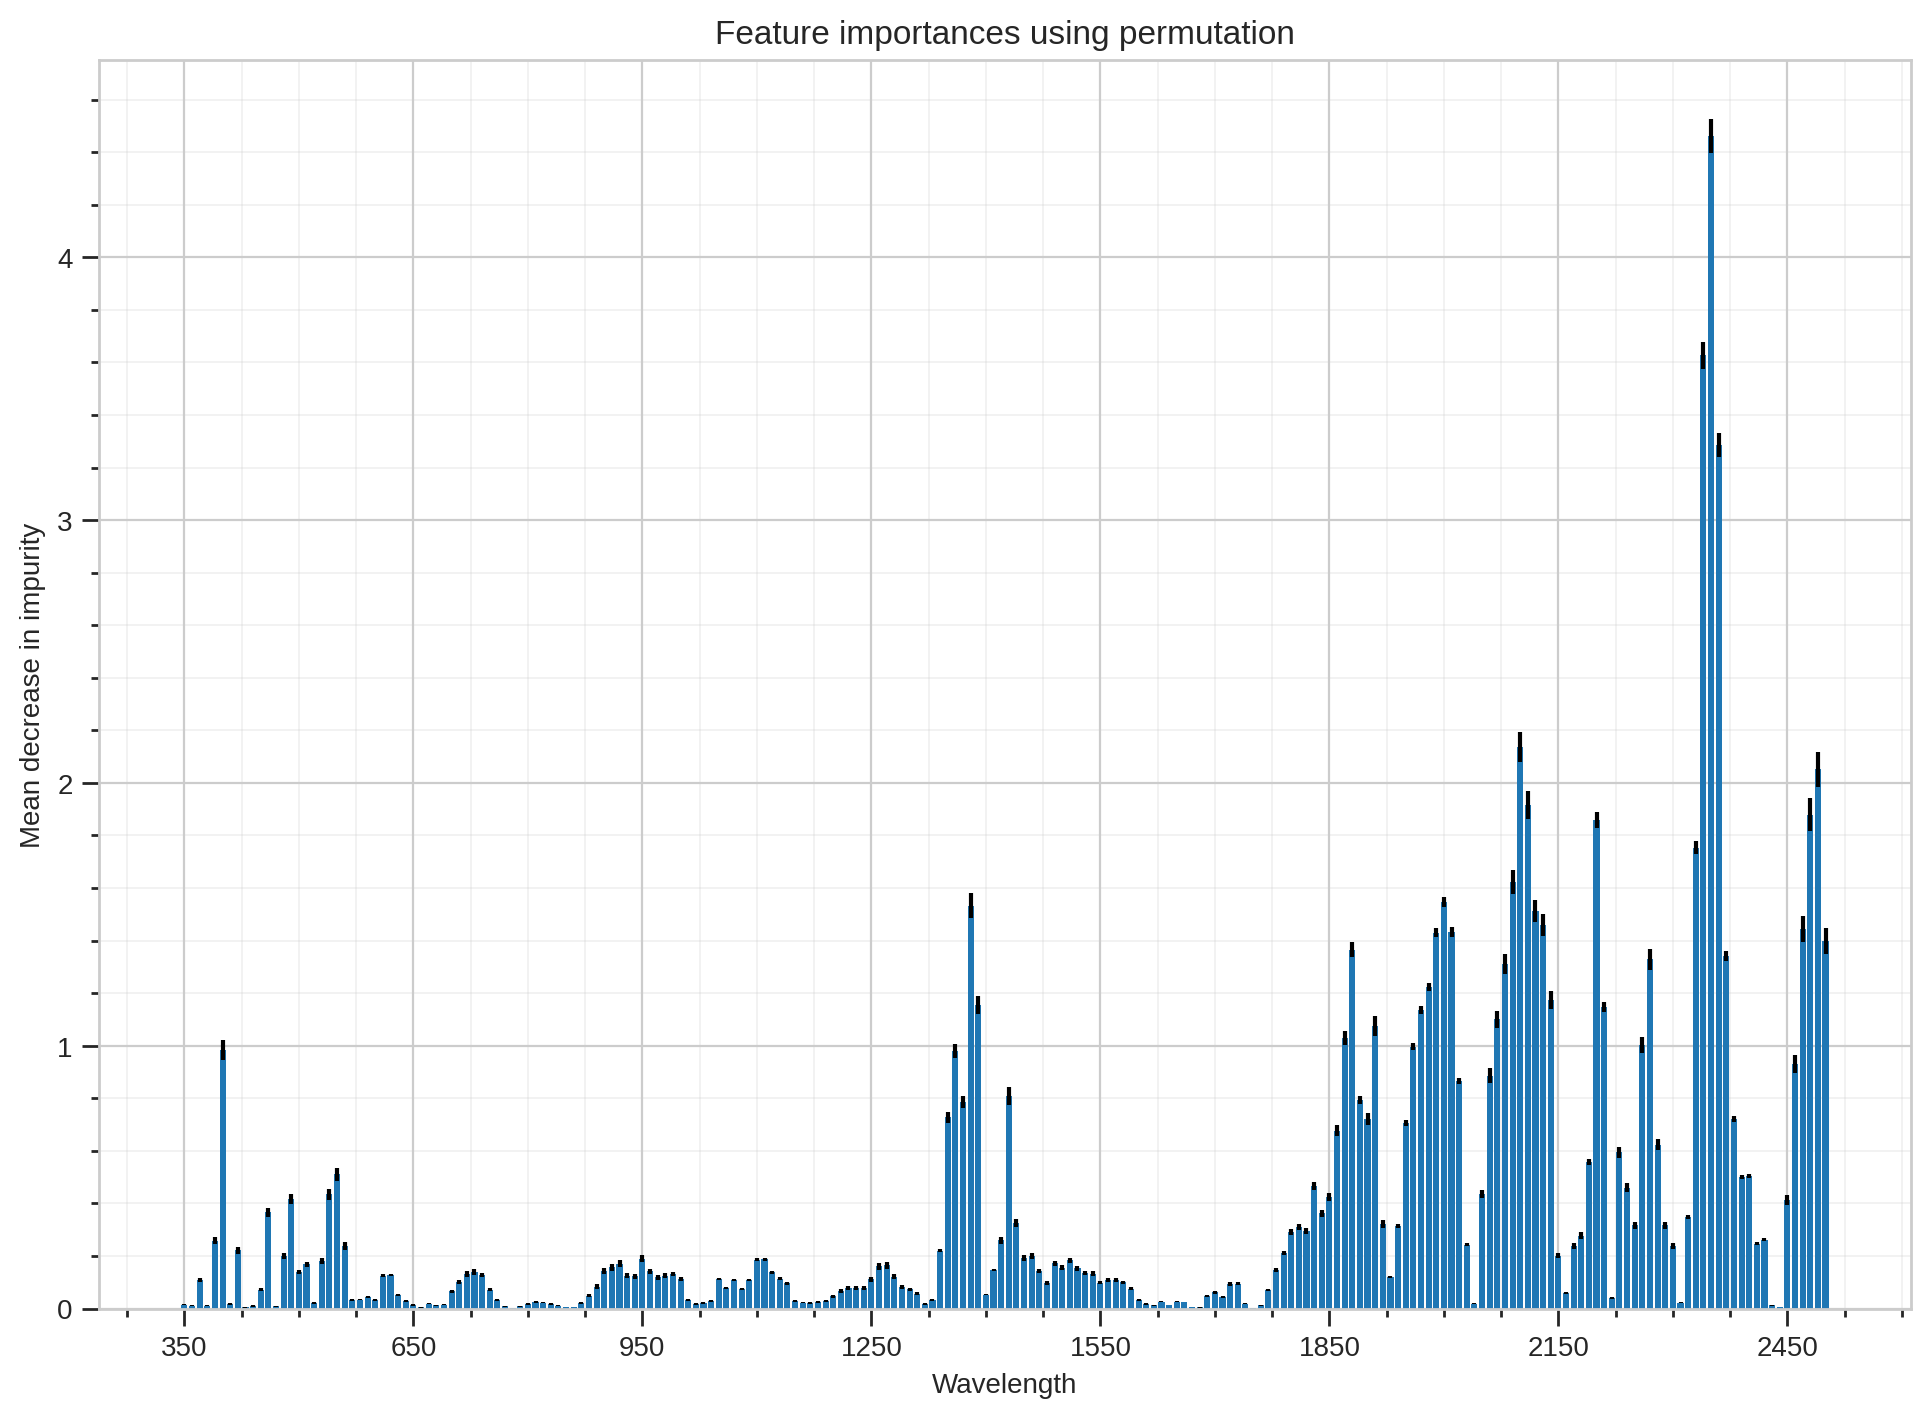

In [10]:
ax = xai.bar_plot_permutation_importance(results.iloc[0]["model"])